# Topic analysis of covid-19 related literature

## Datasets

The corpus of documents has been retrieved from [LitCovid](https://www.ncbi.nlm.nih.gov/research/coronavirus/), a curated open-resource literature of pubmed research papers related to new coronavirus disease COVID-19, and from [medRxiv and bioRxiv COVID-19 SARS-CoV-2](https://connect.biorxiv.org/relate/content/181) preprints. The text of each document, composed by the concatenation of titles and abstracts, has been tokenized, stemmed, and filtered by stopwords. Duplicate documents, due in some case to edited paper available also on preprint servers, have been removed by comparing the title string with Levenshtein distance.

In [ ]:
import pandas as pd
import json
from RISparser import readris

dois=[]
docs = []
titles = []
source = []
with open('data/06202020.litcovid.export.ris', 'r') as bibliography_file:
    entries = readris(bibliography_file)
    for entry in entries:
        dois.append(entry['doi'])
        titles.append(entry['title'])
        docs.append(entry['title'] +' '+ entry['abstract'])
        source.append('pubmed')

with open('data/biomed-covid.json') as json_file:
    data = json.load(json_file)

for i in data['rels']:
    #if not i['rel_doi'] in dois:
    dois.append(i['rel_doi'])
    titles.append(i['rel_title'])
    docs.append(i['rel_title']+' '+i['rel_abs'])
    source.append(i['rel_site'])

print(len(docs))
df = pd.DataFrame({'doi':dois,'title':titles,'txt':docs,'source':source})

df['txt'] = df['txt'].str.lower()

df = df[df['txt'].str.match('\w')]

df.shape


In [ ]:
# compute title similarity to search for duplicates
from Levenshtein import ratio
import numpy as np

tt = df['title'].values
#n = len(tt)
#nl = int((n*(n-1))/2)
#DT = np.zeros(nl)
#vratio = np.vectorize(ratio)

dropidx=[]
for i in range(len(tt)):
    for j in range(i):
        #k = int(nl - (n-i)*((n-i)-1)/2) + j - i - 1
        if ratio(tt[i],tt[j])>0.9:
            dropidx.append(j)

print(len(dropidx))
dropidx = np.unique(dropidx)
print(len(dropidx))

# remove duplicated entries
df = df[~df.index.isin(dropidx)]


## Tokenization, stemming, and stop words removing

The corpus text content, composed by title and abstract, has been processed to extract tokens, i.e. alphanumeric sequence of characters separated by space. Punctuation and pure numbers have been removed. Each word has then been reconducted to its root lemma to normalize the vocabulary and avoid redudant words due to morphological and inflexional endings in English. Finally common english words has been removed.

In [ ]:
# Tokenize, Step, and Stop words
import nltk
import re
import pickle
import string  
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stops = stopwords.words("english")
stops.extend(['et','al','editor','review','abstract','result','conslusion','spacing','href','html','http','title', 'stats', 'bio'])

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

print('nltk version: ' + nltk.__version__)

def rm_munnezz(tk):
    return [w for w in tk if (w not in string.punctuation) and (not re.match(r'\d+',w)) and (not re.match(r'^[^a-zA-Z]',w))]

def uscore_intra_sym(tk):
    return [re.sub('[^a-zA-Z\d\s]','_',w) for w in tk]

def stem(tw):
    return [stemmer.stem(word) for word in tw]

def stop(sl):
    return [w for w in sl if not w in stops]

f = open('results/docs.pckl', 'rb')
df = pickle.load(f)
f.close()

tokens = df['txt'].apply(nltk.word_tokenize)
token_words = tokens.apply(rm_munnezz)
token_words = token_words.apply(uscore_intra_sym)
stemmed_list = token_words.apply(stem)
meaningful_words = stemmed_list.apply(stop)

#meaningful_words = token_words.apply(stop)

df['processed'] = meaningful_words.apply(" ".join)


f = open('results/docs.pckl', 'wb')
pickle.dump(df, f)
f.close()

df.shape

## Topic model hyperparameters optimization

LDA hyperparameter optimization include the search for an optimal number of topics T. A grid search has been performed within a rage of values. Perplexity has been adopted as a measure of fitness to choose the optimal number of topics. Alpha and Beta parameters have been left to 1/T, recognized as optimal value.

In [ ]:
# Search for optimal number of topics
import pickle
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import sklearn
print('sklearn version: ' + sklearn.__version__)


f = open('results/docs.pckl', 'rb')
df = pickle.load(f)
f.close()

vectoriser = CountVectorizer(max_df=0.2,min_df=2,
                             #max_features=10000,
                             ngram_range=(1,1))
doc_train = vectoriser.fit_transform(df['processed'])

perplexity = []
score = []
tt = []
topics = (5,10,20,30,40,50,60,70,80,90,100)
for T in topics:
    print(T)
    # Fit LDA to the data 
    LDA = LatentDirichletAllocation(n_components = T, 
                                    learning_method='batch',
                                    verbose=0, random_state=0,
                                    n_jobs=25)
    lda = LDA.fit(doc_train)
    perplexity.append(lda.perplexity(doc_train))
    score.append(lda.score(doc_train))
    tt.append(T)
    

df_scores = pd.DataFrame({'T':tt,'score':score,'perplexity':perplexity})

# save results on file
f = open('results/topic_scores.pckl', 'wb')
pickle.dump(df_scores, f)
f.close()


sklearn version: 0.21.3
5
10
20
30
40


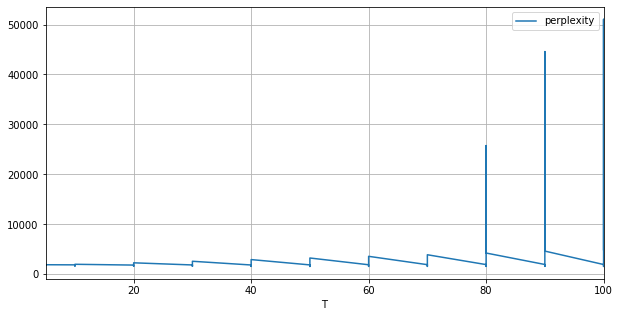

In [76]:
# plot perplexity vs number of topics
import matplotlib.pyplot as plt
import numpy as np
import pickle


f = open('results/topic_scores.pckl', 'rb')
df_scores = pickle.load(f)
f.close()

#plt.subplots(ncols=4,figsize=(25, 5))
df_scores.plot(kind='line',x='T',y='perplexity',grid=True,figsize=(10,5))
   

## Learn topics from the corpus



(27092, 18558)


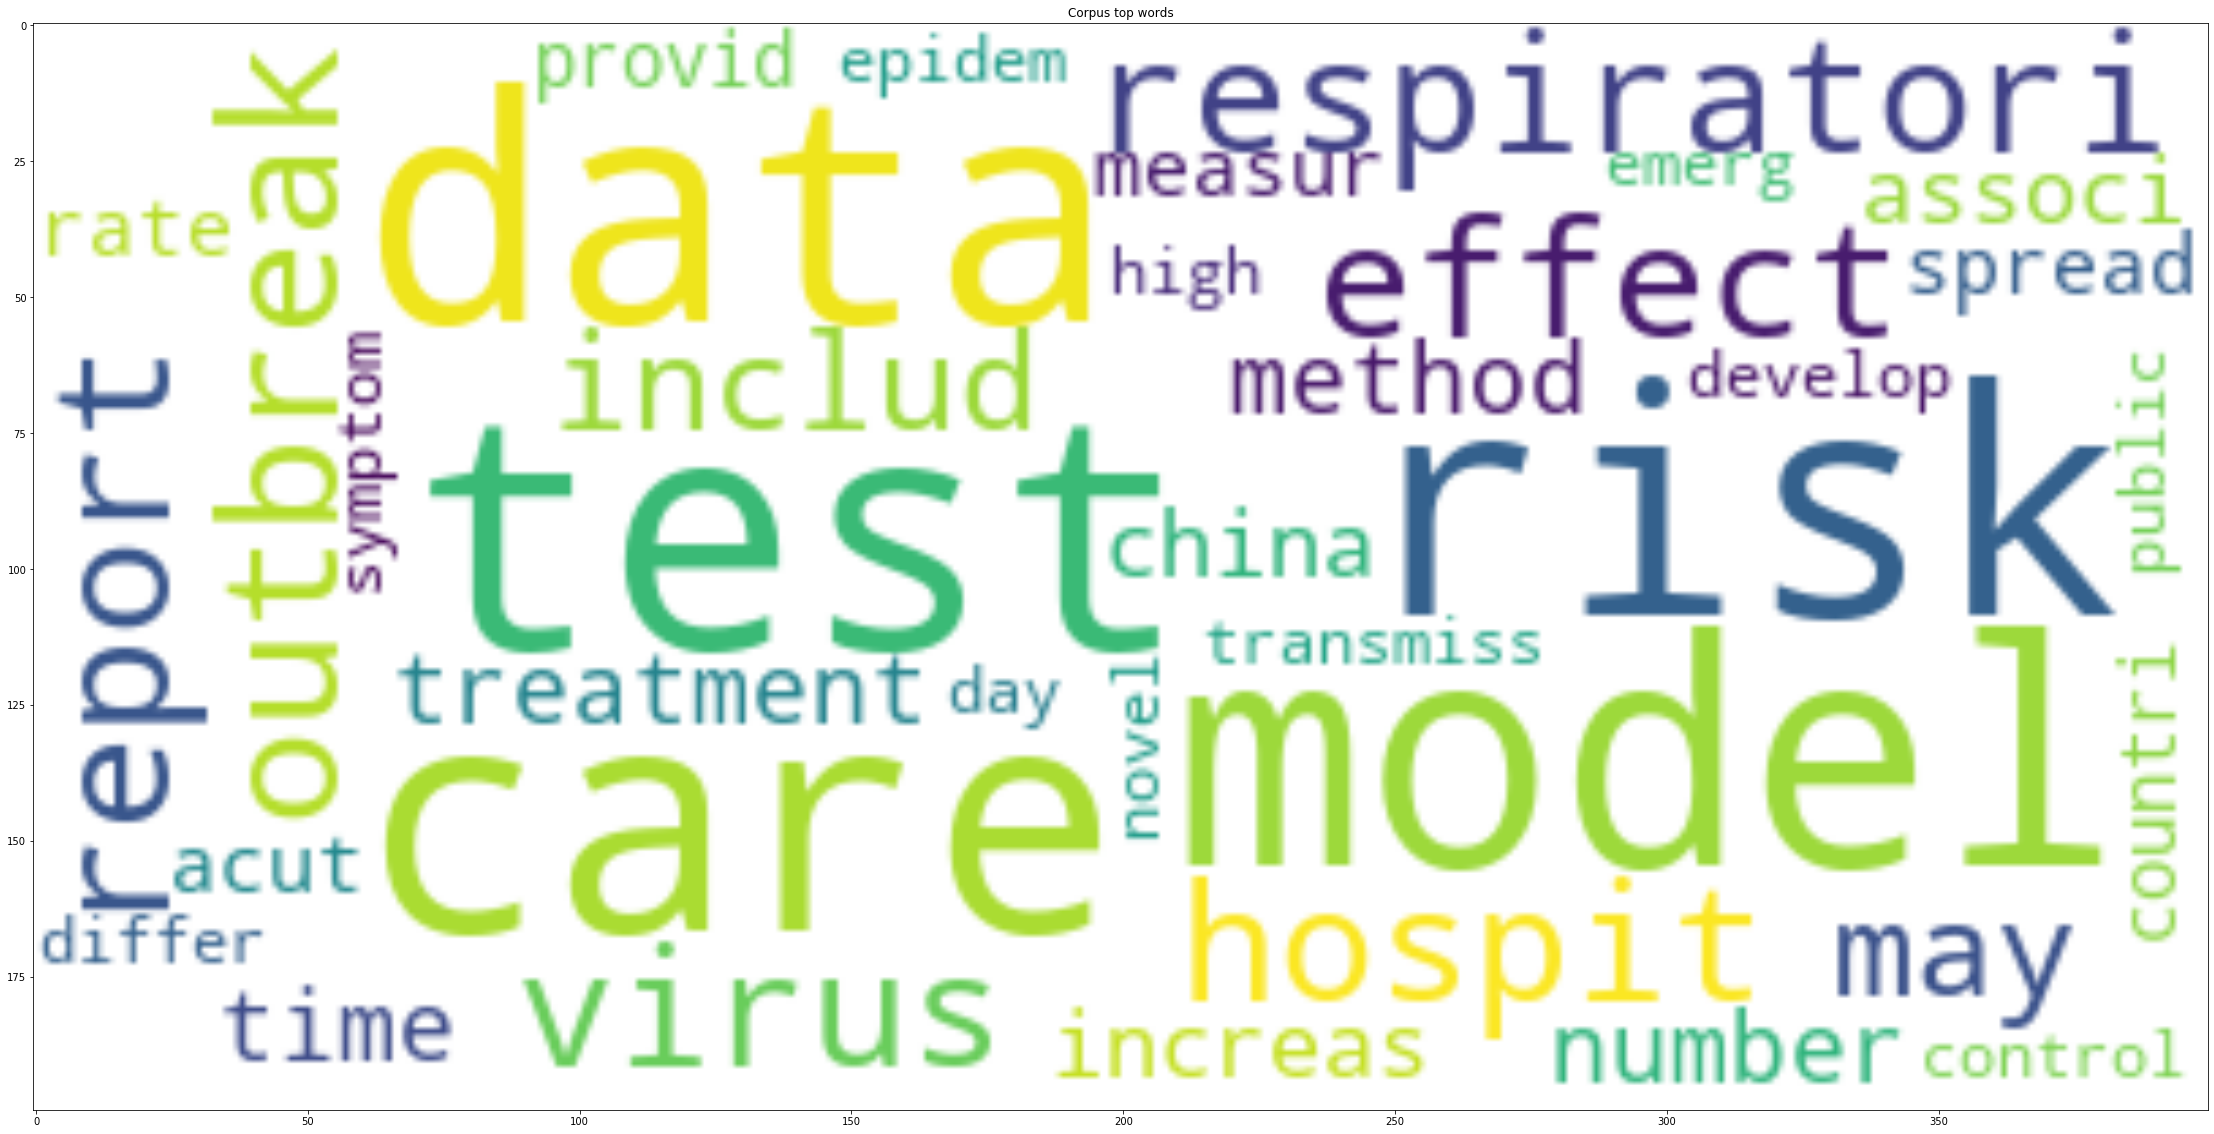

In [35]:
# Compute of words frequencies

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import numpy as np
import pickle

f = open('results/docs.pckl', 'rb')
df = pickle.load(f)
f.close()

vectorizer = CountVectorizer(max_df=0.2,min_df=2,ngram_range=(1,1))
X = vectorizer.fit_transform(df['processed'])

print(X.shape) # check shape of the document-term matrix

terms_count = X.sum(axis=0)
terms_count = terms_count / float(terms_count.max())
dict_word_frequency = {}

terms = vectorizer.get_feature_names()
for i in range(len(terms)):
    dict_word_frequency[terms[i]] = terms_count[0,i]    


wcloud = WordCloud(background_color="white",mask=None, max_words=1000,\
                        max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                        contour_width=3,contour_color='black')
wcloud.generate_from_frequencies(dict_word_frequency)

plt.figure(figsize=(50,20))
plt.imshow(wcloud, interpolation='bilinear',fontsize=50)
plt.title('Corpus top words')
plt.show()



In [37]:
import pickle


# ghet the optimal number of topics from grid search results
f = open('results/topic_scores.pckl', 'rb')
df_scores = pickle.load(f)
f.close()


n_topics = 40
a = 0.01
b = 0.01
#model = TruncatedSVD(n_components=n_topics)
#topic_matrix = model.fit_transform(X)
        
model = LatentDirichletAllocation(n_components=n_topics, 
                                    #doc_topic_prior = a,
                                    #topic_word_prior = b,
                                    learning_method='batch',
                                    verbose=0, random_state=0,
                                    n_jobs=25)
topic_matrix = model.fit_transform(X)

topic_matrix.shape



f = open('results/topic_model.pckl', 'wb')
pickle.dump(topic_matrix, f)
f.close()

In [ ]:
import math   
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
terms_count = 25
numtopics = len(model.components_)

terms = vectorizer.get_feature_names()

ncol=5
nrow = int(math.ceil(numtopics/ncol))
fig, ax = plt.subplots(nrows=nrow, ncols=ncol,figsize=(25, 30))

#Looping over lda components to get topics and their related terms with high probabilities
for idx,topic in enumerate(model.components_):    
    #print('Topic# ',idx)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    #print(','.join( word for word in topic_words))
    #print("")
    dict_word_frequency = {}
    
    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]    
    wcloud = WordCloud(background_color="white",mask=None, max_words=100,\
                        max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                        contour_width=3,contour_color='black')
    wcloud.generate_from_frequencies(dict_word_frequency)
    i = idx // 5
    j = idx % 5
    ax[i,j].imshow(wcloud, interpolation='bilinear')
    ax[i,j].set_axis_off()
    ax[i,j].set_title('Topic %d' % idx)

plt.show()
#plt.savefig("Topic#"+str(idx+1), format="png")
  


In [38]:

terms = vectorizer.get_feature_names()

def topic_top_words(model, feature_names, n_top_words):
    tword=[]
    for topic_idx, topic in enumerate(model.components_):
        #message = "Topic #%d: " % topic_idx
        message = ",".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(message)
    return(tword)

# Define helper functions
def doc_topic1(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def doc_topic2(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys


ttop = topic_top_words(model, terms, 6)
topic = [ttop[i] for i in doc_topic(topic_matrix)]

df['topic2']=topic
print(ttop)
print(len(ttop))

['number,countri,rate,death,estim,epidem', 'model,predict,test,individu,epidem,paramet', 'data,inform,research,analysi,network,learn', 'protein,spike,bind,antibodi,vaccin,human', 'associ,ci,risk,mortal,level,hospit', 'risk,diabet,associ,factor,age,ci', 'social,distanc,peopl,measur,physic,impact', 'cell,ace2,express,human,lung,receptor', 'children,survey,particip,knowledg,respond,among', 'care,system,healthcar,servic,provid,respons', 'women,neurolog,pregnant,pregnanc,report,neonat', 'ultrasound,skin,lesion,saudi,cutan,manifest', 'cardiac,cardiovascular,heart,letter,ed,emerg', 'hydroxychloroquin,treatment,chloroquin,hcq,drug,azithromycin', 'ct,imag,chest,pneumonia,lung,find', 'mask,face,africa,lesson,learn,african', 'test,posit,detect,antibodi,sampl,swab', 'cluster,new,famili,york,citi,state', 'ventil,respiratori,oxygen,mechan,intub,failur', 'china,wuhan,outbreak,epidem,provinc,number', 'protect,care,worker,person,healthcar,risk', 'hospit,age,day,year,admiss,median', 'mental,psycholog,an

In [72]:
# categorie francesca
f = open('results/docs.pckl', 'rb')
df = pickle.load(f)
f.close()

frdois = ['10.1101/2020.05.12.091256','10.3390/jcm9040982']
cls = ['network']*2
frdois.extend(['10.1080/07391102.2020.1756411','10.1038/d41586-020-01221-y','10.1016/j.compbiomed.2020.103670'])
cls.extend(['vaccine_serological']*3)
frdois.extend(['10.1038/s41591-020-0901-9'])
cls.extend(['scRNA']*1)
frdois.extend(['10.1101/2020.05.21.108506','10.1101/2020.04.09.034942','10.1101/2020.03.30.016790','10.1016/j.meegid.2020.104351'])
cls.extend(['phylo']*4)
frdois.extend(['10.13140/RG.2.2.20588.10886','10.1093/bib/bbw051','10.1093/bib/bbw051','10.1101/2020.03.11.986836','10.1016/j.gendis.2020.04.002'])
cls.extend(['drug_docking']*5)

print(len(cls))
frcls = dict(zip(frdois,cls))

t = [frcls.get(i,'NA') for i in df['doi']]
df['francesca'] = t


15


In [70]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

f = open('results/topic_model.pckl', 'rb')
topic_matrix = pickle.load(f)
f.close()

#tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
#                        n_iter=1000, verbose=1, random_state=0, angle=0.75)
#vectors = tsne_model.fit_transform(topic_matrix)


umap_model = umap.UMAP(n_neighbors=30, min_dist=0.5, random_state=12)
vectors = umap_model.fit_transform(topic_matrix)




In [73]:
import matplotlib.pyplot as plt

    
df['x'] = vectors[:,0]
df['y'] = vectors[:,1]


#df[df.francesca!='NA']
groups = df.groupby('topic')

fig = plt.figure(figsize=(20,20))
for name, group in groups:
    plt.scatter(x=group.x, y=group.y,label=name,marker='+')


subdf = df[df.francesca!='NA']
groups = subdf.groupby('francesca')

for name, group in groups:
    plt.scatter(x=group.x, y=group.y,label=name,marker='D',s=500)


#plt.legend()
plt.show()


fig.savefig('codiv-clusters-lda-tsne.pdf')

KeyError: 'topic'

In [ ]:
from scipy.spatial import distance
import numpy as np


out = []
for i in [i for i,x in enumerate(df.francesca) if x != 'NA']:
    jd = []
    print(i)
    for j in range(topic_matrix.shape[0]):
        jd.append(distance.jensenshannon(topic_matrix[i,:],topic_matrix[j,:]))
    jd=np.array(jd)
    top =np.argsort(jd)
    dfp = df.iloc[top[0:20]]
    dfp.to_excel('cluster-'+str(i)+'.xlsx')

        
        
#    distance.jensenshannon


In [ ]:
    top =np.argsort(jd)
    tops =np.sort(jd)
    print(tops[1:3])

In [ ]:
import pickle
from numba import njit, prange
import numpy as np
from scipy.spatial.distance import squareform

# monitor with nvtop

f = open('results/topic_model.pckl', 'rb')
topic_matrix = pickle.load(f)
f.close()

@njit(parallel=True)
def p_distances(mat): 
    D = np.full((mat.shape[0],mat.shape[0]),0.0)
    for i in prange(mat.shape[0]):
        for j in prange(i):
            M = 0.5 * (mat[i,:] + mat[j,:])
            KiM = 0
            KjM = 0
            for k in range(mat.shape[1]):
                KiM += mat[i,k] * np.log2(mat[i,k]/M[k])
                KjM += mat[j,k] * np.log2(mat[j,k]/M[k])
            D[i,j] = 0.5 * (KiM + KjM)
            D[j,i] = 0.5 * (KiM + KjM)
    return D

DD = p_distances(topic_matrix)


DD=squareform(DD)

f = open('results/docs_distances.pckl', 'wb')
pickle.dump(DD, f)
f.close()

In [ ]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import squareform

w=squareform(q)
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(w, method='ward'))

In [1]:
import pickle
from fastcluster import linkage
from scipy.spatial.distance import squareform

f = open('results/docs_distances.pckl', 'rb')
DD = pickle.load(f)
f.close()
ll = linkage(DD, method='ward')
ll.shape


(27091, 4)

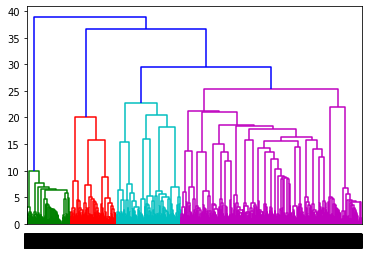

In [68]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
dn = hierarchy.dendrogram(ll)
#cutree = hierarchy.cut_tree(ll,n_clusters=40)
#print(len(np.unique(cutree)))
#df['topic'] = cutree
plt.show()

In [62]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(df['topic'],df['topic2'])
np.sum(cm.max(axis=1))

17494

In [67]:
cm[:,0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [75]:
np.argsort([3,2,5,6])

array([1, 0, 2, 3])